┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.00379                    │              Nfcn = 368              │
│ EDM = 2.82e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

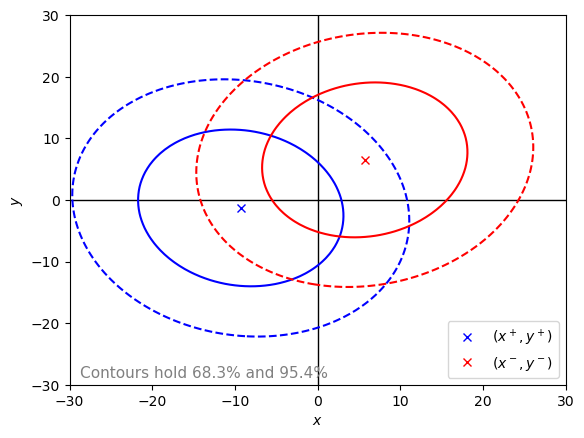

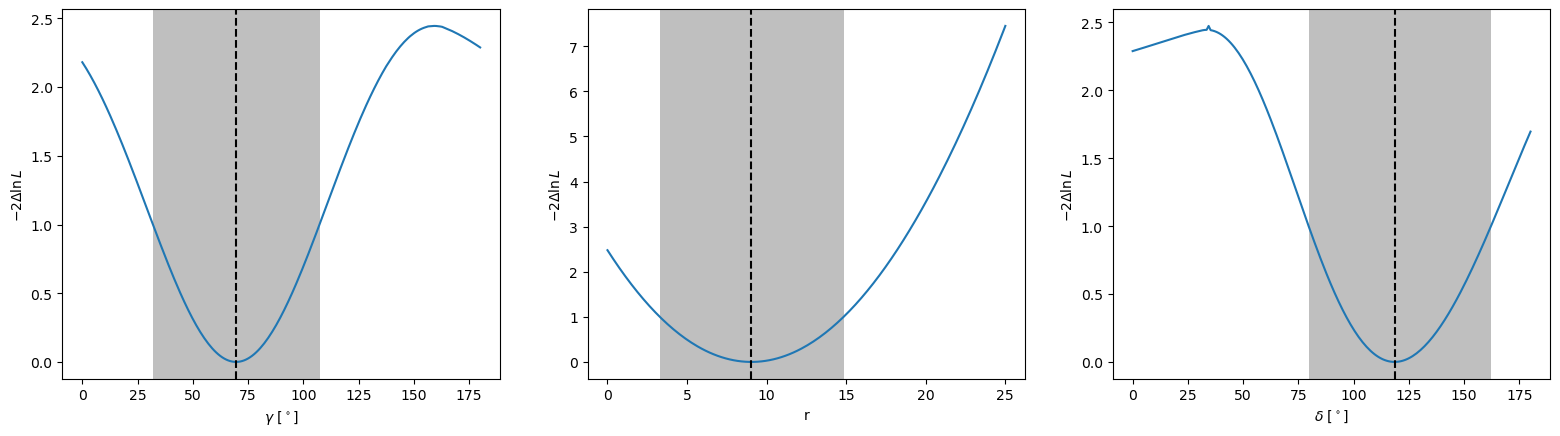

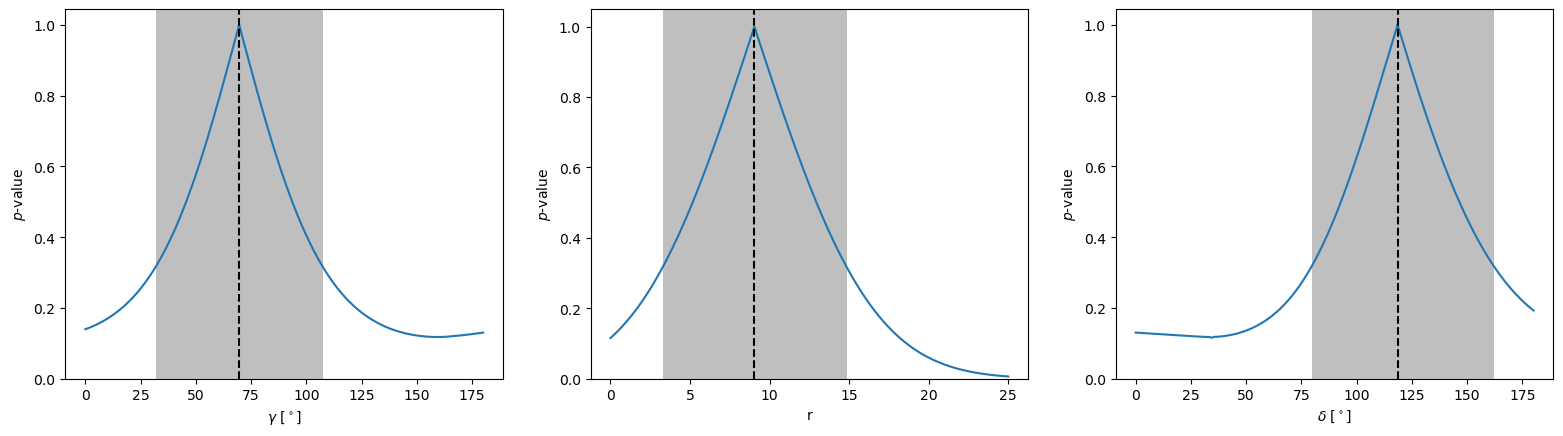

In [3]:
import numpy as np
from scipy.stats import multivariate_normal as mvn, chi2
from iminuit import Minuit
import matplotlib.pyplot as plt

names = [ 'xp', 'yp', 'xm', 'ym' ]
titles = [ '$x^+$', '$y^+$', '$x^-$', '$y^-$' ]
values = np.array( [ -9.3, -1.3, 5.7, 6.5 ] )
errors = np.array( [  8.2,  8.4, 8.2, 8.3 ] )

corr = np.array([
    [  1   , -0.1 , -0.05,   0.1 ],
    [ -0.1 ,  1   ,  0.1 ,  -0.05],
    [ -0.05,  0.1 ,  1   ,   0.1 ],
    [  0.1 , -0.05,  0.1 ,   1   ] ] )

cova = np.ones_like( corr )
for i in range(4):
    for j in range(4):
        cova[i,j] = errors[i] * corr[i,j] * errors[j]

model = mvn( mean=values, cov=cova )
ll_min = model.logpdf( values )

def draw_2d(mi):
    fig, ax = plt.subplots()

    ax.axvline( 0, c='k', lw=1)
    ax.axhline( 0, c='k', lw=1)

    mvnp = mvn( mean=values[:2], cov=cova[:2,:2] )
    mvnm = mvn( mean=values[2:], cov=cova[2:,2:] )

    x = np.linspace(-30,30,100)
    y = np.linspace(-30,30,100)

    X, Y = np.meshgrid(x,y)

    pos = np.dstack([X,Y])
    
    n2llp = -2 * ( mvnp.logpdf( pos ) - mvnp.logpdf( values[:2] ) )
    n2llm = -2 * ( mvnm.logpdf( pos ) - mvnm.logpdf( values[2:] ) )
    
    sigmas = np.array( [1, 2] )
    levels = chi2.ppf( chi2.cdf( sigmas**2, 1), 2 ) 
    ax.contour( X, Y, n2llp, colors='b', linestyles=['-','--'], levels=levels )
    ax.contour( X, Y, n2llm, colors='r', linestyles=['-','--'], levels=levels )

    ax.plot( *values[:2], 'bx', label='$(x^+, y^+)$' )
    ax.plot( *values[2:], 'rx', label='$(x^-, y^-)$' )

    ax.text(0.02, 0.02, 'Contours hold 68.3% and 95.4%', transform=ax.transAxes, fontsize=11, color='0.5' )

    ax.legend(loc='lower right')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    fig.savefig('polar_plot.pdf')

def draw_1d_profile( mi, par, title, ax=None, convert=False ):

    ax = ax or plt.gca()

    x, y, valid = mi.mnprofile(par, subtract_min=True, bound=mi.limits[par], size=200)
    if convert:
        y = chi2.sf(y,1)
    ax.plot( x[valid], y[valid] )

    ax.axvspan( mi.values[par]+mi.merrors[par].lower, mi.values[par]+mi.merrors[par].upper, fc='0.5', alpha=0.5 )
    ax.axvline( mi.values[par], c='k', ls='--' )

    ax.set_xlabel(title)
    ax.set_ylabel('$-2\Delta\ln L$')
    if convert:
        ax.set_ylabel('$p$-value')

    if convert:
        ax.set_ylim(bottom=0)

def n2ll( gamma, r, delta ):
    g = np.radians(gamma)
    d = np.radians(delta)
    xp = r*np.cos(d+g)
    yp = r*np.sin(d+g)
    xm = r*np.cos(d-g)
    ym = r*np.sin(d-g)

    ll_here = model.logpdf( [xp, yp, xm, ym] )

    n2ll = -2*(ll_here - ll_min)

    return n2ll

mi = Minuit( n2ll, gamma=100, r=1, delta=150 )
mi.limits['gamma'] = (0,180)
mi.limits['delta'] = (0,180)
mi.limits['r'] = (0,25)

mi.migrad()
mi.hesse()
mi.minos()
print(mi)

draw_2d(mi)

fig, axes = plt.subplots(1,3, figsize=(19.2, 4.8))
for par, title, ax in zip(['gamma','r','delta'], ['$\gamma$ [$^\circ$]', 'r', '$\delta$ [$^\circ$]'], axes.flatten()):
    draw_1d_profile( mi, par, title, ax=ax )
fig.savefig('polar_prof_nll.pdf')

fig, axes = plt.subplots(1,3, figsize=(19.2, 4.8))
for par, title, ax in zip(['gamma','r','delta'], ['$\gamma$ [$^\circ$]', 'r', '$\delta$ [$^\circ$]'], axes.flatten()):
    draw_1d_profile( mi, par, title, ax=ax, convert=True )
fig.savefig('polar_prof_pval.pdf')

plt.show()
